In [ ]:
import shutil
from google.colab import drive
drive.mount("/content/drive")
shutil.copy("/content/drive/MyDrive/Colab Notebooks/PDL/CDataset.zip", "/content")
!unzip -qq 'CDataset.zip'

Mounted at /content/drive


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
from pycocotools import _mask as coco_mask
from ultralytics import YOLO

In [ ]:
augments = """- Albumentations:
    horizontal_flip: true
    vertical_flip: true
    """


In [ ]:
def main():
    model = YOLO("yolov8x-seg.pt")
    model.train(
        # Project
        project="HuBMAP",
        name="yolov8x-seg",

        # Random Seed parameters
        deterministic=True,
        seed=2137,

        # Data & model parameters
        data="COCOdataset/coco.yaml",
        save=True,
        save_period=5,
        pretrained=True,
        imgsz=512,

        # Training parameters
        epochs=20,
        batch=4,
        workers=8,
        val=True,
        device=0,

        # Optimization parameters
        lr0=0.013,
        patience=3,
        optimizer="SGD",
        momentum=0.947,
        weight_decay=0.0005,
        close_mosaic=3,
    )

In [ ]:
if __name__ == '__main__':
    main()

100%|██████████| 137M/137M [00:01<00:00, 142MB/s]
Ultralytics YOLOv8.0.145 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=COCOdataset/coco.yaml, epochs=20, patience=3, batch=4, imgsz=512, save=True, save_period=5, cache=False, device=0, workers=8, project=HuBMAP, name=yolov8x-seg, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=2137, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=3, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript,

In [ ]:
dirlist = os.listdir("COCOdataset/val/images")
print(dirlist[:5])

['f4e45b48ccf6.tif', 'f34dfcdbd7c5.tif', 'f0cfdfc066fe.tif', 'e8758c97b189.tif', 'f4b0c5cb8593.tif']



image 1/1 /content/COCOdataset/val/images/f4b0c5cb8593.tif: 512x512 8 blood_vessels, 75.5ms
Speed: 1.1ms preprocess, 75.5ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 512)


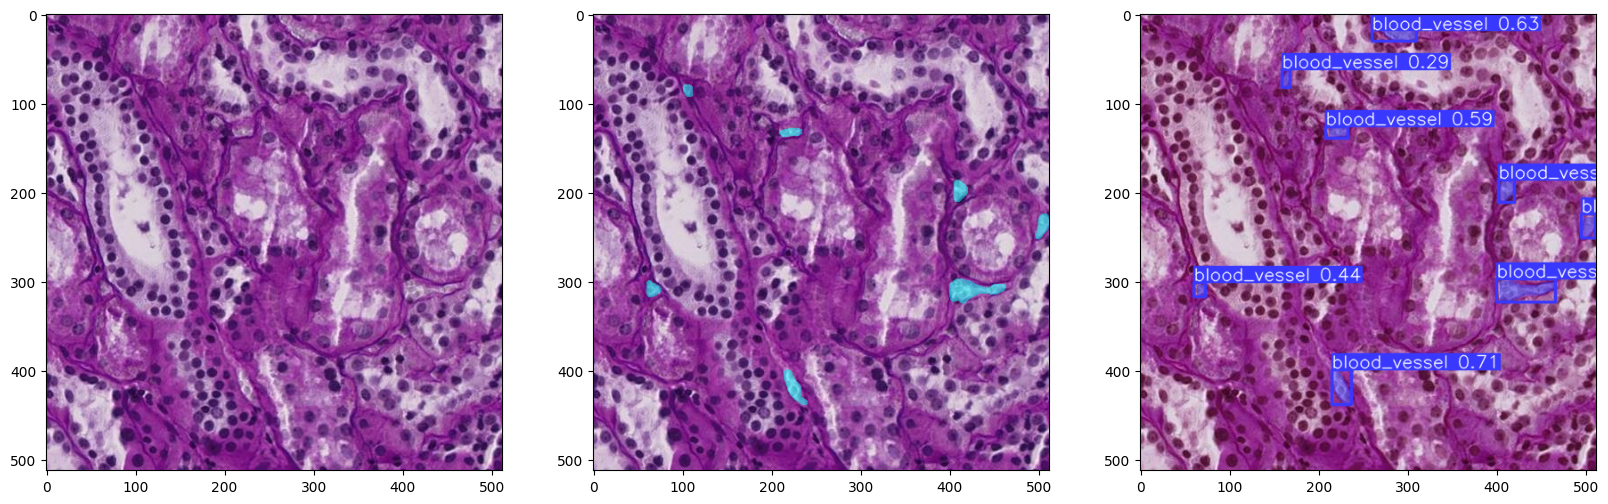

In [ ]:
fix, ax = plt.subplots(1,3, figsize = (20, 10))

model = YOLO("HuBMAP/yolov8x-seg/weights/best.pt")
history = model.predict("COCOdataset/val/images/f4b0c5cb8593.tif")[0]
image = history.plot()
image_collection.display_image("f4b0c5cb8593", axes = [ax[0], ax[1]])
ax[2].imshow(image)
plt.show()

## Plotting data

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os, os.path

In [ ]:
class ImageCollection():
  def __init__(self, images_path: str, annotations_filepath: str,
               annotation_filetype: str = '.txt', image_filetype: str = '.tif',
               normalized_coordinates: bool = True):
    self.normalized_coordinates = normalized_coordinates

    self.images_path = images_path
    self.image_filetype = image_filetype
    self.annotations_filepath = annotations_filepath
    self.annotation_filetype = annotation_filetype

    self.fileList = [os.path.splitext(im) for im in os.listdir(images_path)]
    self.current_image_id = 0

    self.current_image = None
    self.current_annotation = []
    self.annoted_image = None

    #self.next()

  def __load_image(self, image_name: str = None) -> None:
    if not image_name:
      current_image_path = (self.images_path+ "/" +
                            ''.join(self.fileList[self.current_image_id]))
      self.current_image = Image.open(current_image_path)
    else:
      current_image_path = (self.images_path+ "/" + image_name +
                            self.image_filetype)
      self.current_image = Image.open(current_image_path)

  def __load_annotation(self, image_name: str = None) -> None:
    self.current_annotation = []
    self.annoted_image = self.current_image.copy()
    if not image_name:
      current_annotation_path = (self.annotations_filepath + "/" +
                                self.fileList[self.current_image_id][0] +
                                self.annotation_filetype)
    else:
      current_annotation_path = (self.annotations_filepath + "/" +
                                image_name +
                                self.annotation_filetype)

    with open(current_annotation_path) as annotations:
      for line in annotations:
        annotation = line.split(' ')
        en_type = int(annotation[0])
        coords = [int(float(x)*512.0) for x in annotation[1:]]
        self.current_annotation.append({'type': en_type,
                                        'coords': coords})

  def __create_annotation_layer(self):
    for annotation in self.current_annotation:
      if annotation["type"] == 0:
        ImageDraw.Draw(self.annoted_image, 'RGBA').polygon(annotation["coords"],
                                          fill=(0, 255, 255, 128))
      elif annotation["type"] == 1:
        ImageDraw.Draw(self.annoted_image, 'RGBA').polygon(annotation["coords"],
                                               fill=(255, 0, 255, 128))
      else:
        ImageDraw.Draw(self.annoted_image, 'RGBA').polygon(annotation["coords"],
                                               fill=(255, 255, 0, 128))

  def display_current_image(self, axes = None) -> None:
    if not axes:
      fig, ax = plt.subplots(1,2, figsize=(15,8))
      fig.suptitle("Image: "+self.fileList[self.current_image_id][0])
      ax[0].imshow(self.current_image)
      ax[1].imshow(self.annoted_image)
    elif len(axes) == 2:
      axes[0].imshow(self.current_image)
      axes[1].imshow(self.annoted_image)
    elif len(axes) == 1:
      axes.imshow(self.annoted_image)

  def next(self) -> None:
    self.__load_image()
    self.__load_annotation()
    self.__create_annotation_layer()
    self.display_current_image()
    self.current_image_id += 1

  def display_image(self, image_id: str, axes = None) -> None:

    self.__load_image(image_id)
    self.__load_annotation(image_id)

    self.__create_annotation_layer()
    self.display_current_image(axes)

In [ ]:
image_collection = ImageCollection("/content/COCOdataset/val/images", "/content/COCOdataset/val/labels")

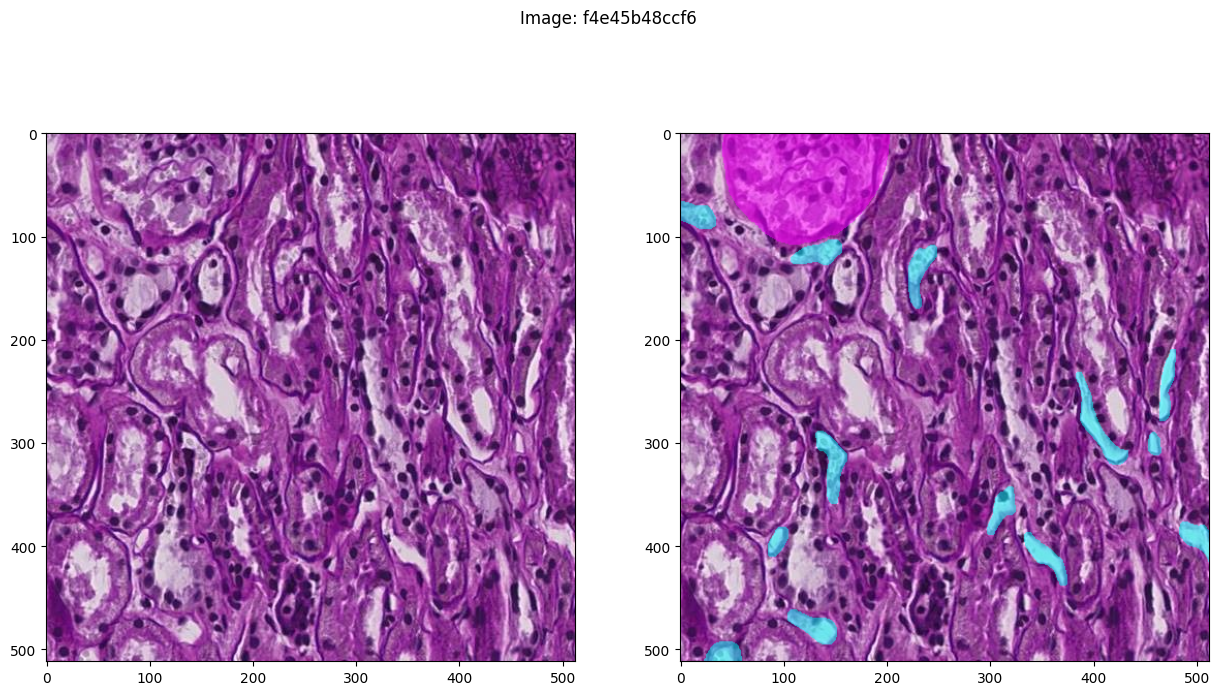

In [ ]:
image_collection.next()